In [1]:
import numpy as np
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from random import randint, shuffle
from collections import defaultdict

from torch_geometric.utils import from_networkx, to_networkx

from GOOD.utils.synthetic_data import synthetic_structsim
from GOOD.utils.args import args_parser, CommonArgs
from GOOD import config_summoner
from GOOD.kernel.main import initialize_model_dataset
from GOOD.kernel.pipeline_manager import load_pipeline
from GOOD.ood_algorithms.ood_manager import load_ood_alg
from GOOD.utils.initial import reset_random_seed
import GOOD.kernel.pipelines.xai_metric_utils as xai_utils


In [2]:
def plot_base(p):
    plt.figure(figsize=(2,2))
    nx.draw(p)
    plt.show()

house, _ = synthetic_structsim.house(start=0)
crane, _ = synthetic_structsim.crane(start=0)
dircycle, _ = synthetic_structsim.dircycle(start=0)
path, _ = synthetic_structsim.path(start=0, width=11)
# plot_base(crane)

## Load models and dataset

In [2]:
DATASET = "GOODMotif/basis"
SEED = 1
DEVICE = "cuda:1"

In [3]:
args = CommonArgs(argv=None)
config_path = f"./final_configs/{DATASET}/covariate/LECI.yaml"
args.process_args_manual(config_path)
args.random_seed = SEED
args.exp_round = SEED
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["task"] = "test"
config["device"] = DEVICE
leci, loader = initialize_model_dataset(config)
leci_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
leci_pipeline = load_pipeline(config.pipeline, config.task, leci, loader, leci_ood_algorithm, config)
leci_pipeline.load_task(load_param=True, load_split="id") 


args = CommonArgs(argv=None)
args.random_seed = SEED
args.exp_round = SEED
config_path = f"./final_configs/{DATASET}/covariate/CIGA.yaml"
args.process_args_manual(config_path)
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["task"] = "test"
config["device"] = DEVICE
ciga, _ = initialize_model_dataset(config)
ciga_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
ciga_pipeline = load_pipeline(config.pipeline, config.task, ciga, loader, ciga_ood_algorithm, config)
ciga_pipeline.load_task(load_param=True, load_split="id") 


args = CommonArgs(argv=None)
args.random_seed = SEED
args.exp_round = SEED
config_path = f"./final_configs/{DATASET}/covariate/GSAT.yaml"
args.process_args_manual(config_path)
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["task"] = "test"
config["device"] = DEVICE
gsat, _ = initialize_model_dataset(config)
gsat_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
gsat_pipeline = load_pipeline(config.pipeline, config.task, gsat, loader, gsat_ood_algorithm, config)
gsat_pipeline.load_task(load_param=True, load_split="id") 

#IN#
-----------------------------------
    Task: test
Wed Feb 21 16:56:14 2024
#IN#Load Dataset GOODMotif
#D#Dataset: {'train': GOODMotif(18000), 'id_val': GOODMotif(3000), 'id_test': GOODMotif(3000), 'val': GOODMotif(3000), 'test': GOODMotif(3000), 'task': 'Multi-label classification', 'metric': 'Accuracy'}
#D# Data(edge_index=[2, 64], x=[18, 1], node_gt=[18], edge_gt=[64], y=[1], env_id=[1], num_nodes=18)
Data(edge_index=[2, 52], x=[19, 1], node_gt=[19], edge_gt=[52], y=[1], env_id=[1], num_nodes=19)
#IN#Loading model...
#D#Init GINFeatExtractor
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
Using feature sampling := feat
self.EF = 0
#D#Init GINFeatExtractor
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
#D#Using the fixed _explain_ functionality
#D#Using no mitigation (None)
#D#Using th

(0.5013333333333333, tensor(2.0231, device='cuda:0'))

## How likely is to pick an edge in the explanation in NEC?

In [8]:
def sample_edges(G_ori, data, where_to_sample, alpha, edge_index_to_remove=None, ratio=None):
    # keep each spu/inv edge with probability alpha
    G = G_ori.copy()
    edges = [(u.item(), v.item()) for u, v in edge_index_to_remove.T]    
    
    shuffle(edges)
    num_to_remove = max(1, int(len(G.edges()) * ratio * (1-alpha)))
    edge_remove = edges[:num_to_remove] #remove the 1-alpha% of the undirected edges
    G.remove_edges_from(edge_remove)
    G.remove_edges_from([(v,u) for v,u in G.edges() if not G.has_edge(u,v)])
    G.remove_nodes_from(list(nx.isolates(G)))

    # count how many GT edges where removed
    edge_gt = {(u.item(),v.item()): bool(data.edge_gt[i]) for i, (u,v) in enumerate(data.edge_index.T)} 
    edges_in_gt = sum([edge_gt[e] for e in edge_remove])
    return G, edges_in_gt

In [5]:
##
# Extract edge scores
##

edge_scores, graphs, labels = [], [], []
for data in loader["id_val"]:    
    data = data.to(config.device)
    edge_score = leci.get_subgraph(
        data=data,
        edge_weight=None,
        ood_algorithm=leci_ood_algorithm,
        do_relabel=False,
        return_attn=False,
        ratio=None
    )
    for j, g in enumerate(data.to_data_list()):
        g.ori_x = data.ori_x[data.batch == j]
        edge_scores.append(edge_score[data.batch[data.edge_index[0]] == j].detach().cpu())
        graphs.append(g.detach().cpu())
    labels.extend(data.y.detach().cpu().numpy().tolist())
labels = torch.tensor(labels)
graphs_nx = [to_networkx(g, node_attrs=["ori_x"], edge_attrs=["edge_attr"] if not g.edge_attr is None else None) for g in graphs]

if hasattr(graphs[0], "edge_gt"):
    num_gt_edges = torch.tensor([data.edge_gt.sum() for data in graphs])
    num_all_edges = torch.tensor([data.edge_index.shape[1] for data in graphs])
    print("\nGold ratio = ", torch.mean(num_gt_edges / num_all_edges), "+-", torch.std(num_gt_edges / num_all_edges))

causal_subgraphs_r, spu_subgraphs_r, expl_accs_r = {}, {}, {}
for ratio in [0.3, 0.6, 0.9]:
    reset_random_seed(config)    
    causal_subgraphs_r[ratio], spu_subgraphs_r[ratio], expl_accs_r[ratio] = leci_pipeline.get_subragphs_ratio(graphs, ratio, edge_scores) 
    print(f"F1 for r = {ratio} = {np.mean([e[1] for e in expl_accs_r[ratio]]):.3f}")
    print(f"WIoU for r = {ratio} = {np.mean([e[0] for e in expl_accs_r[ratio]]):.3f}")


Gold ratio =  tensor(0.3045) +- tensor(0.1614)
F1 for r = 0.3 = 0.621
WIoU for r = 0.3 = 0.547
F1 for r = 0.6 = 0.603
WIoU for r = 0.6 = 0.660
F1 for r = 0.9 = 0.473
WIoU for r = 0.9 = 0.660


In [11]:
metric = "nec++"

removed_edges_in_gt = defaultdict(list)
for ratio in [0.3, 0.6, 0.9]:
    reset_random_seed(config)    
    causal_subgraphs, spu_subgraphs, expl_accs = causal_subgraphs_r[ratio], spu_subgraphs_r[ratio], expl_accs_r[ratio]

    for i in range(len(graphs)):
        G = graphs_nx[i].copy()
        if len(G.edges()) == 0:
            continue

        if metric == "nec++":
            alpha = max(config.nec_alpha_1 - 0.1 * (j // 3), 0.1)
        else:
            alpha = config.nec_alpha_1
        
        G_sampled, edges_in_gt = sample_edges(G, graphs[i], "inv", alpha, causal_subgraphs[i], ratio=ratio)
        removed_edges_in_gt[ratio].append(edges_in_gt)
            

Text(0.5, 1.0, 'Drop edges depending on |G|')

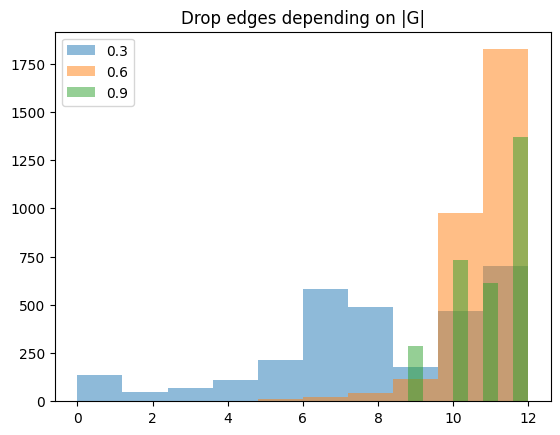

In [12]:
for ratio in [0.3, 0.6, 0.9]:
    plt.hist(removed_edges_in_gt[ratio], alpha=0.5, label=ratio);
plt.legend()
plt.title("Drop edges depending on |G|")

Text(0.5, 1.0, 'Drop edges depending on |R|')

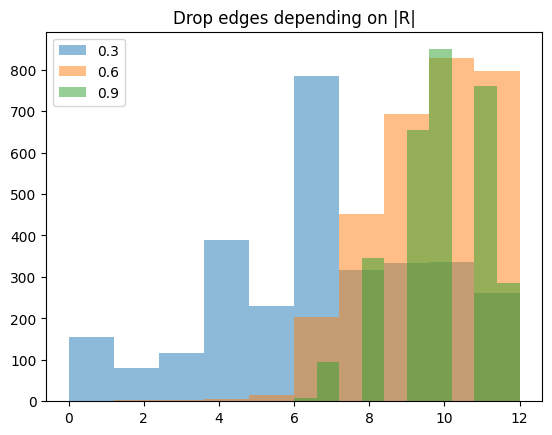

In [10]:
for ratio in [0.3, 0.6, 0.9]:
    plt.hist(removed_edges_in_gt[ratio], alpha=0.5, label=ratio);
plt.legend()
plt.title("Drop edges depending on |R|")

Text(0.5, 1.0, 'Always remove 1')

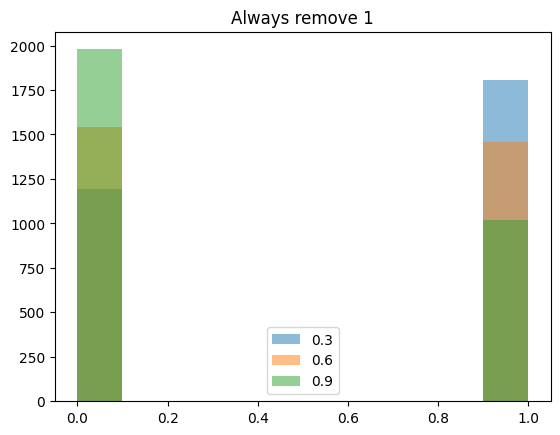

In [7]:
for ratio in [0.3, 0.6, 0.9]:
    plt.hist(removed_edges_in_gt[ratio], alpha=0.5, label=ratio);
plt.legend()
plt.title("Always remove 1")

## NX WL